In [49]:
# Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne import concatenate_epochs
import numpy as np
import mne
from scipy.stats import f_oneway, ttest_rel, wilcoxon
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection, multipletests
mne.set_log_level('warning')

### Important note: After switching AutoReject in front of ICA and Changing the Timings F0.5 Score of 1029 increases while accuracy decreases for in Condition and Leave one Cond out

Old Scores Within Cond:

1009 F0.5: 0.759491523600765 Accuracy: 0.26337142857142853

1029 F0.5: 0.7760042600224989 Accuracy: 0.31047619047619046

Old Scores Leave one Out:
1009: F0.5: 0.32178535075958165 Accuracy: 0.2043574186431329

1009: F0.5:0.39111933245433406 Accuracy 0.24676979611190134

In [52]:
df_1009 = pd.read_csv("results\\classification_results_single_cond_1009_first.csv")
df_1029 = pd.read_csv("results\\classification_results_single_cond_1029.csv")
print(df_1009['SVM_F0.5_Score'].mean(), df_1009['SVM_Accuracy'].mean())
print(df_1029['SVM_F0.5_Score'].mean(), df_1029['SVM_Accuracy'].mean())

0.759491523600765 0.26337142857142853
0.8726292946877182 0.18556547619047614


In [53]:
df_1009 = pd.read_csv("results\\cross_condition_results_first_1009.csv")
df_1029 = pd.read_csv("results\\cross_condition_results_1029.csv")
print(df_1009['SVM_F0.5'].mean(), df_1009['SVM_Accuracy'].mean())
print(df_1029['SVM_F0.5'].mean(), df_1029['SVM_Accuracy'].mean())

0.32178535075958165 0.2043574186431329
0.507552823844709 0.1347202465623518


## Some Statistics

In [55]:
marker = 1009
conditions = ['Joystick', 'Leaning', 'Omnideck', 'Walking']
n_participants = 14
channels_of_interest = ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']

# Create structure to hold trial-level peak and baseline values
peak_neg_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]
baseline_all = [{cond: [] for cond in conditions} for _ in range(n_participants)]

for cond in conditions:
    for p in range(1, n_participants + 1):
        if p in [4] or (p == 3 and cond == 'Omnideck') or (p == 7 and (cond == 'Joystick' or cond == 'Leaning')) or (p == 13 and cond == 'Walking') :
            # Missing data case — append np.nan to indicate this condition is absent
            peak_neg_all[p-1][cond] = np.nan
            baseline_all[p-1][cond] = np.nan
            continue

        path = f'epochs\\P{p:03d}\\'
        all_epochs = []

        for i in range(1, 3):  # Assume 2 sessions per condition
            if marker == 1009:
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_first_{marker}_epo.fif'
            else:
                filename = f'sub-P{p:03d}_ses-{cond}{i}_epochs_{marker}_epo.fif'
            epochs = mne.read_epochs(path + filename, preload=True)
            all_epochs.append(epochs)

        epochs = concatenate_epochs(all_epochs, verbose=False)
        epochs = epochs.pick(channels_of_interest)

        # Apply autoreject
        #ar = AutoReject(n_jobs=8, verbose=False)
        #epochs = ar.fit_transform(epochs)

        # Crop for MRCP and baseline windows
        if marker == 1009:
            epochs_mrcp = epochs.copy().crop(tmin=-1.5, tmax=0)
            epochs_base = epochs.copy().crop(tmin=-6, tmax=-2)
        else:
            epochs_mrcp = epochs.copy().crop(tmin=-0.5, tmax=1)
            epochs_base = epochs.copy().crop(tmin=-5, tmax=-1)

        # Extract data (trials x channels x timepoints)
        mrcp_data = epochs_mrcp.get_data()  # shape: (n_trials, n_channels, n_times)
        base_data = epochs_base.get_data()

        # Peak negativity: min across time for each trial and channel
        peak_neg = np.min(mrcp_data, axis=2)  # shape: (n_trials, n_channels)
        baseline_mean = np.mean(base_data, axis=2)  # shape: (n_trials, n_channels)

        peak_neg_all[p-1][cond] = peak_neg  # shape: trials × channels
        baseline_all[p-1][cond] = baseline_mean


C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\3275486699.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\3275486699.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\3275486699.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\3275486699.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = concatenate_epochs(all_epochs, verbose=False)
C:\Users\stadl\AppData\Local\Temp\ipykernel_3236

In [56]:
pvals = np.full((n_participants, len(conditions), len(channels_of_interest)), np.nan)
significant = np.zeros_like(pvals, dtype=bool)

# Paired t-tests Between the mean of baseline and peak negativity
for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        peak = peak_neg_all[p][cond]
        base = baseline_all[p][cond]

        if isinstance(peak, float) and np.isnan(peak):
            continue  # Skip missing data

        for ch_idx in range(len(channels_of_interest)):
            # trial-level comparison
            t_stat, p_val = ttest_rel(base[:, ch_idx], peak[:, ch_idx])
            pvals[p, c_idx, ch_idx] = p_val
            significant[p, c_idx, ch_idx] = p_val < 0.05

# Correction for Mulitple comparisons
# Flatten across channels for correction
for p in range(n_participants):
    for c_idx, cond in enumerate(conditions):
        raw_pvals = pvals[p, c_idx, :]
        if np.isnan(raw_pvals).all():
            continue
        reject, corrected_pvals, _, _ = multipletests(raw_pvals, alpha=0.05, method='bonferroni')
        pvals[p, c_idx, :] = corrected_pvals
        significant[p, c_idx, :] = reject


data = []
for p_idx, p_data in enumerate(peak_neg_all):
    if p_idx == 6:  # Skip participant 7 (0-indexed)
        continue
    for cond, arr in p_data.items():
        if isinstance(arr, float) or arr is np.nan:
            continue
        for trial in arr:  # shape: (n_channels,)
            avg_peak_neg = np.mean(trial)  # average across channels
            data.append({
                'Participant': f'P{p_idx + 1}',
                'PeakNeg': avg_peak_neg,
                'Condition': cond
            })
# P, avg across channel peak negativity, cond (max number of entries is 152 for 1009 and 1029 per subject; 19x2x4)
df = pd.DataFrame(data)

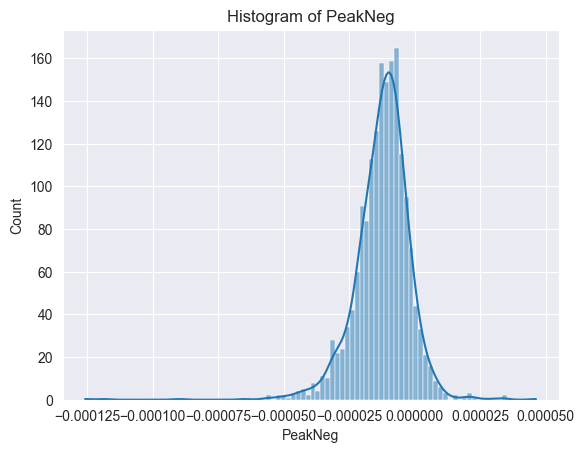

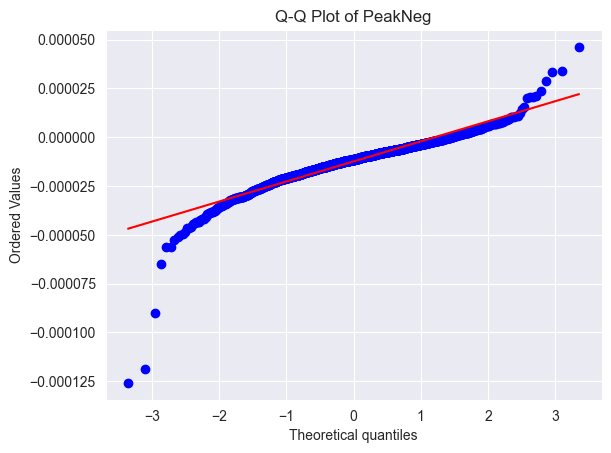

In [57]:
# Checking for normality
sns.histplot(df['PeakNeg'], kde=True)
plt.title('Histogram of PeakNeg')
plt.show()


stats.probplot(df['PeakNeg'], dist="norm", plot=plt)
plt.title('Q-Q Plot of PeakNeg')
plt.show()

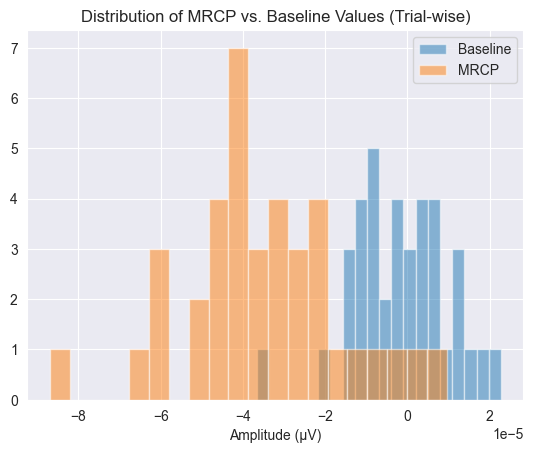

In [58]:
participant = 0
cond = 'Leaning'
ch_idx = channels_of_interest.index('FCz')

peak = peak_neg_all[participant][cond][:, ch_idx]
base = baseline_all[participant][cond][:, ch_idx]

plt.hist(base, bins=20, alpha=0.5, label='Baseline')
plt.hist(peak, bins=20, alpha=0.5, label='MRCP')
plt.title("Distribution of MRCP vs. Baseline Values (Trial-wise)")
plt.xlabel("Amplitude (µV)")
plt.legend()
plt.show()

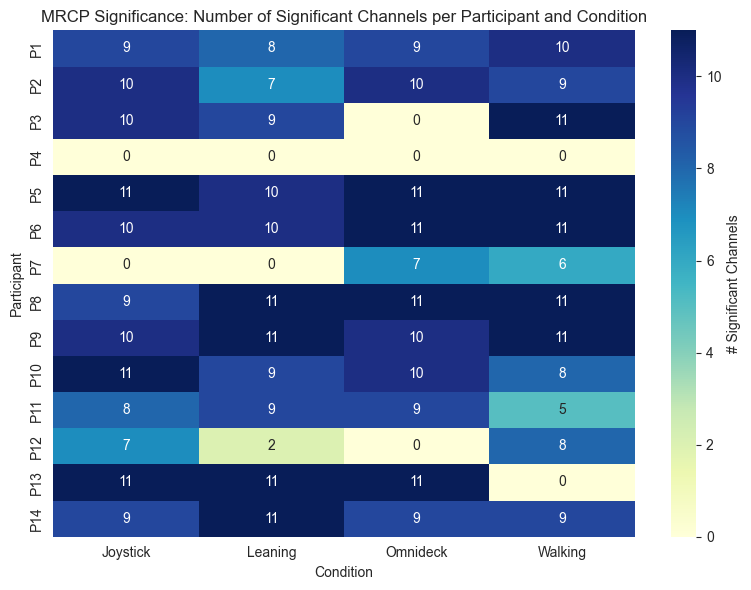

<Figure size 640x480 with 0 Axes>

In [59]:
# Step 1: Summarize the number of significant channels per participant per condition
# shape: (14 participants, 4 conditions)
sig_counts = significant.sum(axis=2)

# Step 2: Convert to a DataFrame for easy labeling
participant_labels = [f"P{p+1}" for p in range(14)]
condition_labels = ['Joystick', 'Leaning', 'Omnideck', 'Walking']

df_ = pd.DataFrame(sig_counts, index=participant_labels, columns=condition_labels)

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': '# Significant Channels'})
plt.title("MRCP Significance: Number of Significant Channels per Participant and Condition")
plt.xlabel("Condition")
plt.ylabel("Participant")
plt.tight_layout()
plt.show()
plt.savefig(f'{marker}_significant_count.png')


In [60]:
df

,Participant,PeakNeg,Condition
0,P1,-0.000021,Joystick
1,P1,-0.000018,Joystick
2,P1,-0.000019,Joystick
3,P1,-0.000014,Joystick
4,P1,-0.000011,Joystick
...,...,...,...
1732,P14,-0.000008,Walking
1733,P14,-0.000017,Walking
1734,P14,-0.000014,Walking
1735,P14,0.000007,Walking


In [61]:
# Group by participant ANOVA
groups = [g['PeakNeg'].values for _, g in df.groupby('Participant')]

f_stat, p_val = f_oneway(*groups)
print(f"F = {f_stat}, p = {p_val}")


k = len(groups)
# Total number of data points
N = sum(len(g) for g in groups)

# Degrees of freedom
df_between = k - 1
df_within = N - k
print(df_between, df_within)

F = 8.257918637435628, p = 2.921124095306211e-14
11 1725


In [62]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df['PeakNeg'],             # dependent variable
    groups=df['Participant'],        # group labels
    alpha=0.05                       # significance level
)

print(tukey)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
participants = df['Participant'].unique()

differs_from_all = []

for participant in participants:
    # Get all pairwise comparisons involving this participant
    matches = tukey_df[(tukey_df['group1'] == participant) | (tukey_df['group2'] == participant)]

    # Check if ALL comparisons were significant (reject == True)
    if matches['reject'].all():
        differs_from_all.append(participant)

print("Participants that differ significantly from ALL others:")
print(differs_from_all)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower upper reject
------------------------------------------------
    P1    P10      0.0 0.0335   0.0   0.0   True
    P1    P11      0.0    0.0   0.0   0.0   True
    P1    P12      0.0 0.3279  -0.0   0.0  False
    P1    P13      0.0    0.0   0.0   0.0   True
    P1    P14      0.0 0.0001   0.0   0.0   True
    P1     P2      0.0    0.0   0.0   0.0   True
    P1     P3      0.0 0.1087  -0.0   0.0  False
    P1     P5      0.0 0.0033   0.0   0.0   True
    P1     P6      0.0 0.2068  -0.0   0.0  False
    P1     P8      0.0 0.0103   0.0   0.0   True
    P1     P9     -0.0    1.0  -0.0   0.0  False
   P10    P11      0.0 0.6617  -0.0   0.0  False
   P10    P12     -0.0 0.9992  -0.0   0.0  False
   P10    P13      0.0 0.4377  -0.0   0.0  False
   P10    P14      0.0 0.9599  -0.0   0.0  False
   P10     P2      0.0 0.1595  -0.0   0.0  False
   P10     P3     -0.0    1.0  -0.0   0.0  False
   P10     P5    

## Difference of MRCP across condition

In [63]:
data = []

for p in range(n_participants):
    if p in [2, 6, 12]:
        continue
    for c_idx, cond in enumerate(conditions):
        peak = peak_neg_all[p][cond]
        if isinstance(peak, float) or peak is None:
            continue  # Skip missing
        # Example: average across trials and selected channels (e.g., Cz, FCz)
        ch_idxs = [channels_of_interest.index(ch) for ch in ['F3', 'Fz', 'F4', 'FC1', 'FCz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2']]
        mean_peak = np.min(peak[:, ch_idxs])
        data.append({
            'participant': p,
            'condition': cond,
            'mean_mrcp': mean_peak
        })

df = pd.DataFrame(data)
#df = df.drop([6, 12], axis=0).reset_index(drop=True)
df

,participant,condition,mean_mrcp
0,0,Joystick,-0.000075
1,0,Leaning,-0.000146
2,0,Omnideck,-0.000159
3,0,Walking,-0.000178
4,1,Joystick,-0.000051
5,1,Leaning,-0.000053
6,1,Omnideck,-0.000096
7,1,Walking,-0.000074
8,4,Joystick,-0.000075
9,4,Leaning,-0.000051


In [64]:
print(df.pivot(index='participant', columns='condition', values='mean_mrcp'))

condition    Joystick   Leaning  Omnideck   Walking
participant                                        
0           -0.000075 -0.000146 -0.000159 -0.000178
1           -0.000051 -0.000053 -0.000096 -0.000074
4           -0.000075 -0.000051 -0.000074 -0.000035
5           -0.000139 -0.000113 -0.000088 -0.000048
7           -0.000109 -0.000095 -0.000056 -0.000074
8           -0.000054 -0.000058 -0.000112 -0.000076
9           -0.000114 -0.000084 -0.000065 -0.000076
10          -0.000090 -0.000092 -0.000096 -0.000109
11          -0.000186 -0.000338 -0.000251 -0.000094
13          -0.000072 -0.000062 -0.000073 -0.000102


In [65]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

anova = AnovaRM(df, depvar='mean_mrcp', subject='participant', within=['condition'])
res = anova.fit()
print(res)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  0.6091 3.0000 27.0000 0.6149



In [66]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

conditions = df['condition'].unique()
pairs = [(a, b) for i, a in enumerate(conditions) for b in conditions[i+1:]]

pvals = []
for a, b in pairs:
    a_vals = df[df['condition'] == a].sort_values('participant')['mean_mrcp']
    b_vals = df[df['condition'] == b].sort_values('participant')['mean_mrcp']
    stat, p = ttest_rel(a_vals, b_vals)
    pvals.append(p)

# Correct for multiple comparisons
rejected, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')

# Print results
for (a, b), p_corr, sig in zip(pairs, pvals_corrected, rejected):
    print(f"{a} vs {b}: p={p_corr:.4f} {'*' if sig else ''}")

Joystick vs Leaning: p=1.0000 
Joystick vs Omnideck: p=1.0000 
Joystick vs Walking: p=1.0000 
Leaning vs Omnideck: p=1.0000 
Leaning vs Walking: p=1.0000 
Omnideck vs Walking: p=1.0000 


## In condition testing results

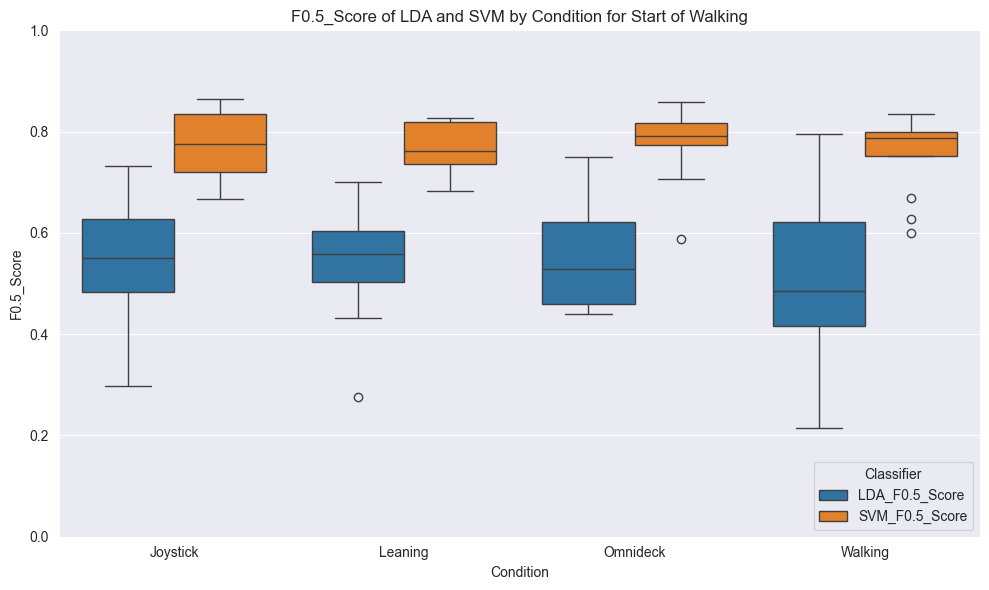

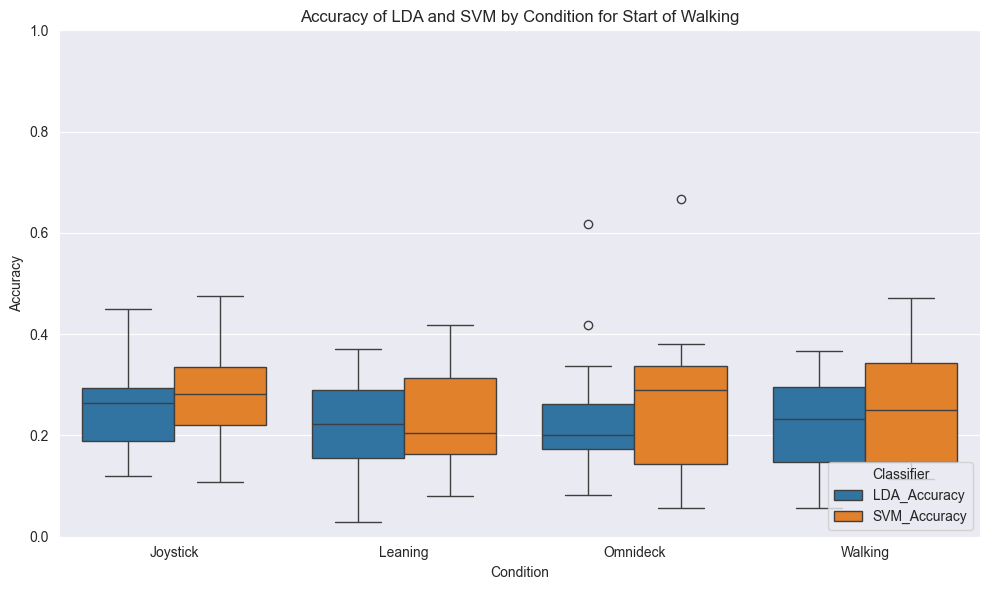

In [75]:
# Load the CSV file
df = pd.read_csv("results\\classification_results_single_cond_first_1009.csv")
measures = ['F0.5_Score', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df,
        id_vars=['Participant', 'Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure} of LDA and SVM by Condition for Start of Walking')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='lower right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_by_cond_first_1009.png')
    plt.show()



In [68]:
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
lda_df = df.pivot(index='Participant', columns='Condition', values='LDA_F0.5_Score')

# SVM pivoted scores
svm_df = df.pivot(index='Participant', columns='Condition', values='SVM_Accuracy')
svm_df

Condition,Joystick,Leaning,Omnideck,Walking
Participant,,,,
1,0.239286,0.139286,0.132143,0.192857
2,0.000000,0.053571,0.157143,0.132143
3,0.153571,0.182143,NaN,0.214286
4,NaN,NaN,NaN,NaN
5,0.328571,0.157143,0.103571,0.107143
6,0.164286,0.203571,0.260714,0.228571
7,NaN,NaN,0.260714,0.135714
8,0.317857,0.292857,0.132143,0.235714
9,0.153571,0.182143,0.228571,0.235714


C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\2046732636.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_F0.5_Score', data=df_cond, palette='crest')


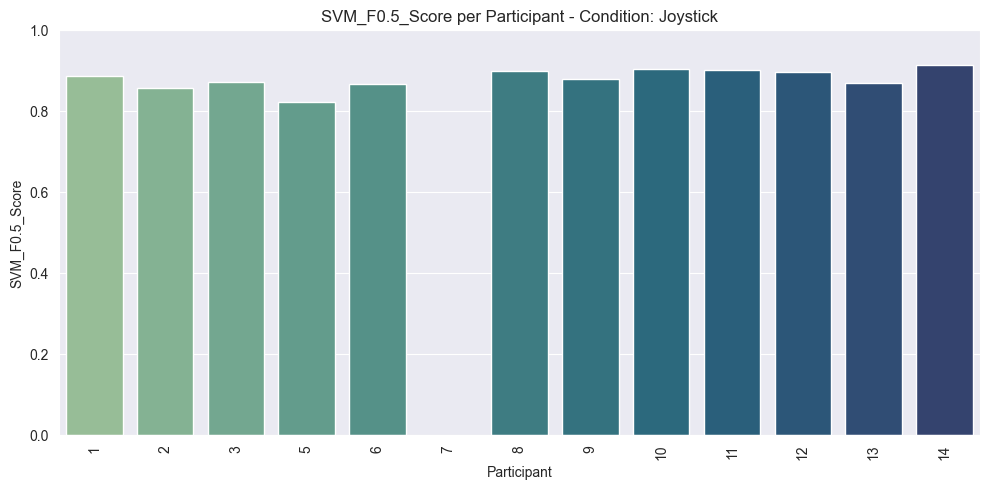

C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\2046732636.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_F0.5_Score', data=df_cond, palette='crest')


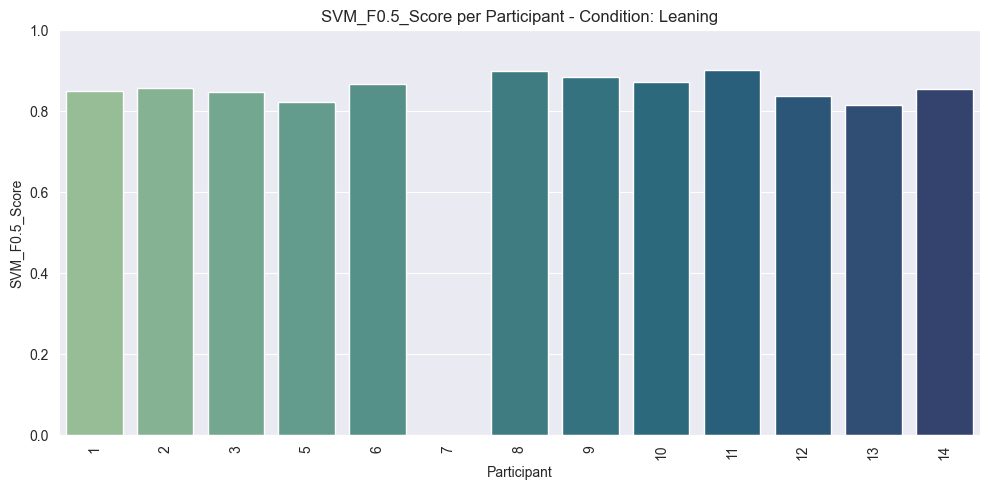

C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\2046732636.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_F0.5_Score', data=df_cond, palette='crest')


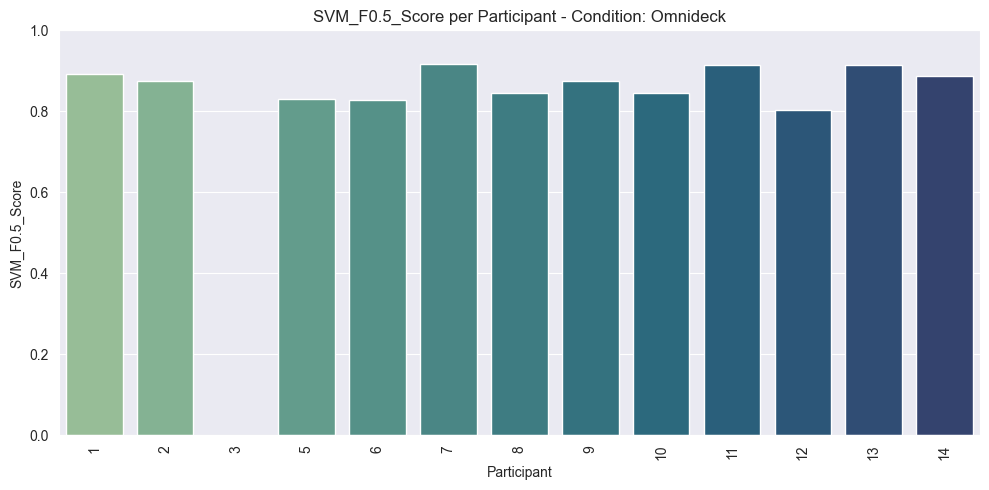

C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\2046732636.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='SVM_F0.5_Score', data=df_cond, palette='crest')


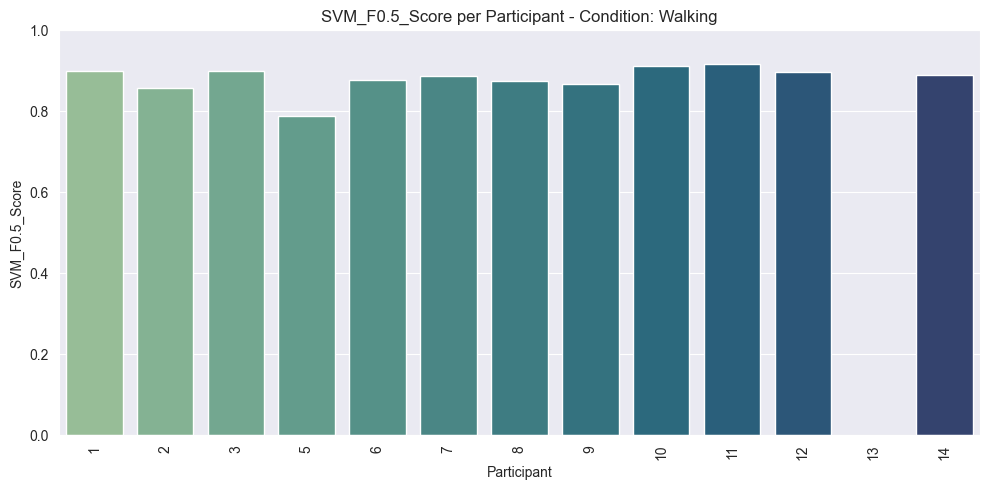

In [72]:
# Load data
df = pd.read_csv("results\\classification_results_single_cond_1029.csv")
df = df[df['Participant'] != 4]
# Get unique conditions
conditions = df['Condition'].unique()

# Loop and plot per condition
for cond in conditions:
    df_cond = df[df['Condition'] == cond].sort_values(by='SVM_F0.5_Score', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Participant', y='SVM_F0.5_Score', data=df_cond, palette='crest')

    plt.title(f'SVM_F0.5_Score per Participant - Condition: {cond}')
    plt.xlabel('Participant')
    plt.ylabel('SVM_F0.5_Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
    plt.tight_layout()
    plt.show()

C:\Users\stadl\AppData\Local\Temp\ipykernel_3236\401613534.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')


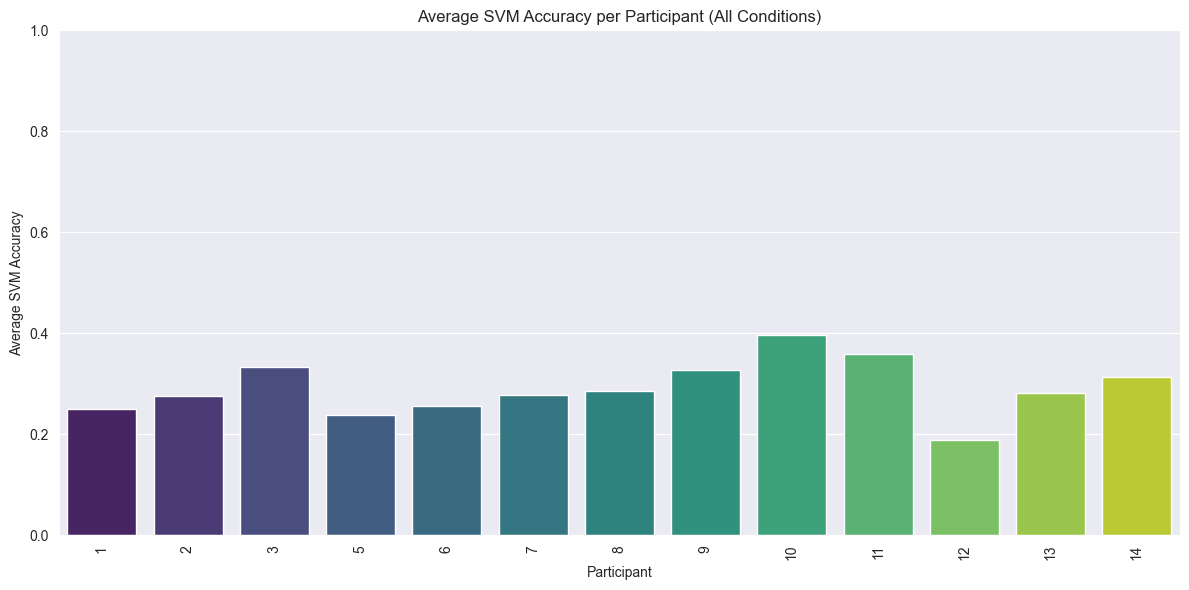

In [20]:
df_avg = df.groupby('Participant')['LDA_Accuracy'].mean().reset_index()

# Sort by average accuracy
df_avg = df_avg.sort_values(by='LDA_Accuracy', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Participant', y='LDA_Accuracy', data=df_avg, palette='viridis')

plt.title('Average SVM Accuracy per Participant (All Conditions)')
plt.xlabel('Participant')
plt.ylabel('Average SVM Accuracy')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [10]:
# Group by Condition and aggregate
agg_stats = df.groupby('Condition').agg(['mean', 'median', 'std'])

# Optional: Clean up column names if needed
agg_stats.columns = ['_'.join(col).strip() for col in agg_stats.columns.values]

# Display the result
print(agg_stats)

           Participant_mean  Participant_median  Participant_std  \
Condition                                                          
Joystick           7.769231                 8.0         4.225988   
Leaning            7.769231                 8.0         4.225988   
Omnideck           7.769231                 8.0         4.225988   
Walking            7.769231                 8.0         4.225988   

           LDA_F0.5_Score_mean  LDA_F0.5_Score_median  LDA_F0.5_Score_std  \
Condition                                                                   
Joystick              0.566135               0.606218            0.094868   
Leaning               0.522652               0.514100            0.087957   
Omnideck              0.467860               0.460832            0.077896   
Walking               0.561190               0.576569            0.110676   

           SVM_F0.5_Score_mean  SVM_F0.5_Score_median  SVM_F0.5_Score_std  \
Condition                                          

Some Results based statistics

In [70]:
# Significant difference between LDA and SVM accuracies
results = []

for condition in df['Condition'].unique():
    subset = df[df['Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_Accuracy', 'SVM_Accuracy']].dropna()

    lda_scores = scores['LDA_Accuracy']
    svm_scores = scores['SVM_Accuracy']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.mean() if not lda_scores.empty else None,
            'SVM mean': svm_scores.mean() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.median(),
        'SVM mean': svm_scores.median(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick        0.672154          0.622070  0.157143  0.157143  None
1   Leaning        0.787046          0.969727  0.157143  0.169643  None
2  Omnideck        0.408462          0.518555  0.182143  0.173214  None
3   Walking        0.265736          0.233398  0.230357  0.221429  None


In [71]:
# Significant difference between LDA and SVM F0.5-Scores
results = []

for condition in df['Condition'].unique():
    subset = df[df['Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_F0.5_Score', 'SVM_F0.5_Score']].dropna()

    lda_scores = scores['LDA_F0.5_Score']
    svm_scores = scores['SVM_F0.5_Score']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.mean() if not lda_scores.empty else None,
            'SVM mean': svm_scores.mean() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.median(),
        'SVM mean': svm_scores.median(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick    9.723843e-07          0.000488  0.688283  0.883158  None
1   Leaning    5.085922e-09          0.000488  0.686790  0.856325  None
2  Omnideck    8.844029e-07          0.000488  0.708550  0.875482  None
3   Walking    1.892657e-07          0.000488  0.744860  0.888471  None


## Transfer Learning Results


In [38]:
df = pd.read_csv("results\\cross_condition_results_first_1009.csv")
df_joystick_mean = np.nanmean(df[df['Test_Condition'] == 'Joystick']['SVM_Accuracy'])
df_leaning_mean = np.nanmean(df[df['Test_Condition'] == 'Leaning']['SVM_Accuracy'])
df_omnideck_mean = np.nanmean(df[df['Test_Condition'] == 'Omnideck']['SVM_Accuracy'])
df_walking_mean = np.nanmean(df[df['Test_Condition'] == 'Walking']['SVM_Accuracy'])
print(np.mean([df_joystick_mean, df_leaning_mean, df_omnideck_mean, df_walking_mean]))

0.2051076886603202


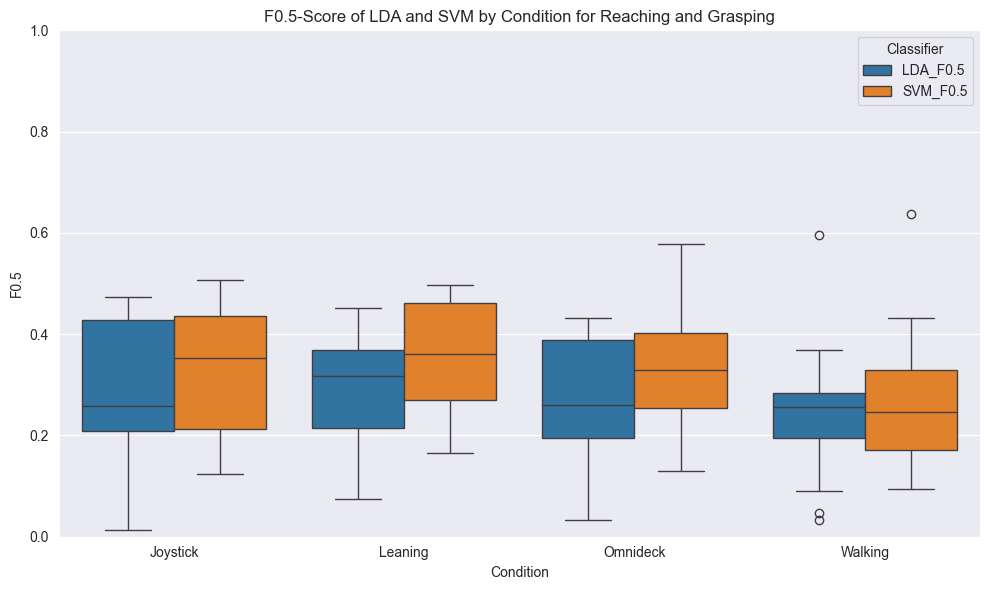

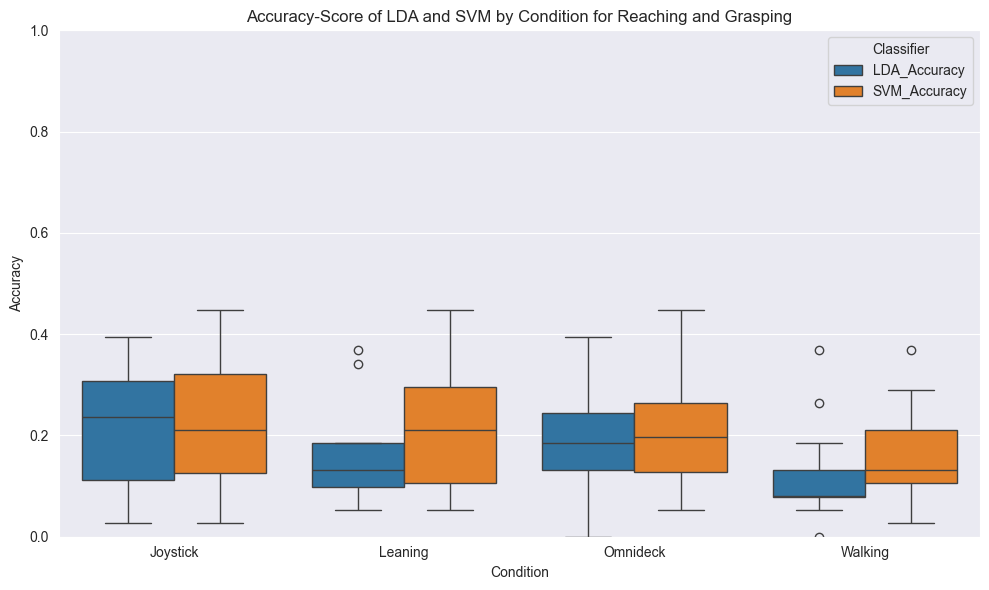

In [39]:
df_transfer = pd.read_csv("results\\cross_condition_results_first_1009.csv")
measures = ['F0.5', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df_transfer,
        id_vars=['Participant', 'Test_Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Test_Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure}-Score of LDA and SVM by Condition for Reaching and Grasping')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='upper right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_leave_one_out_first_1009.png')
    plt.show()


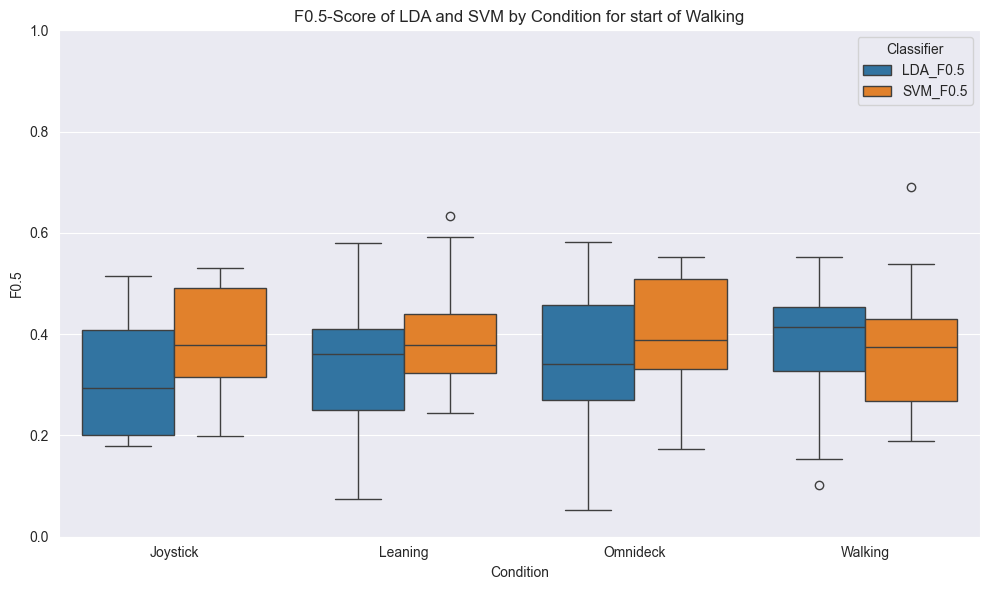

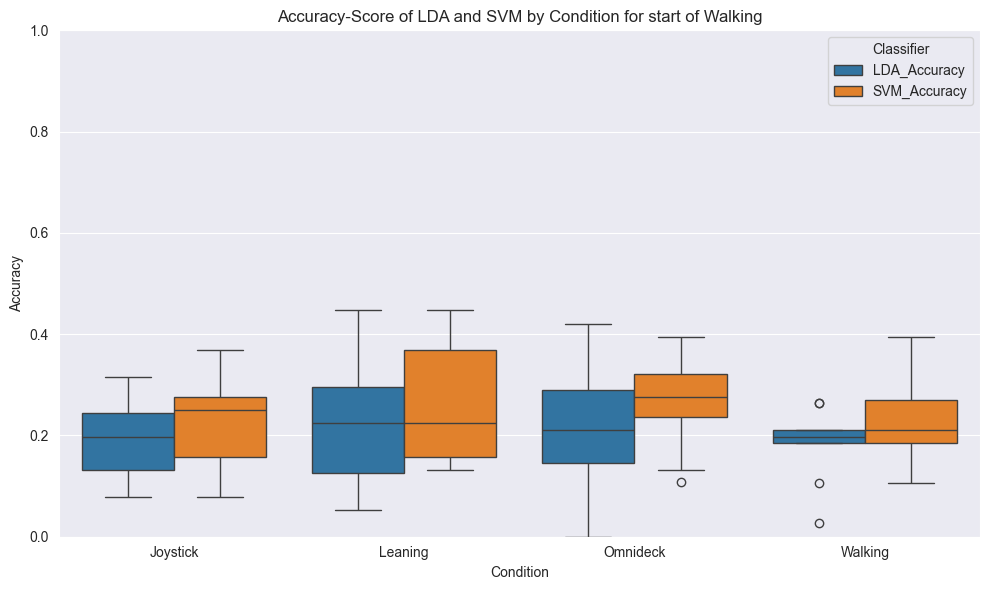

In [40]:
df_transfer = pd.read_csv("results\\cross_condition_results_1029.csv")
measures = ['F0.5', 'Accuracy']
# Assuming your dataframe has columns named: 'Participant', 'condition', 'LDA_accuracy', 'SVM_accuracy'
# Melt the dataframe to long format for seaborn boxplot
for measure in measures:
    df_melted = pd.melt(
        df_transfer,
        id_vars=['Participant', 'Test_Condition'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Test_Condition', y=measure, hue='Classifier', data=df_melted)
    # Add some plot formatting
    plt.title(f'{measure}-Score of LDA and SVM by Condition for start of Walking')
    plt.xlabel('Condition')
    plt.ylim(0, 1)
    plt.ylabel(measure)
    plt.legend(title='Classifier', loc='upper right')
    plt.tight_layout()
    plt.savefig(f'results\\{measure}_leave_one_out_1029.png')
    plt.show()


In [42]:
df

,Participant,Test_Condition,LDA_F0.5,LDA_Accuracy,SVM_F0.5,SVM_Accuracy
0,1,Joystick,0.013021,0.026316,0.213904,0.263158
1,1,Leaning,0.253378,0.052632,0.277778,0.105263
2,1,Omnideck,0.193750,0.189189,0.259434,0.135135
3,1,Walking,0.194257,0.078947,0.259615,0.131579
4,2,Joystick,0.079114,0.027027,0.123626,0.108108
5,2,Leaning,0.229167,0.131579,0.176174,0.105263
6,2,Omnideck,0.032051,0.026316,0.129310,0.105263
7,2,Walking,0.046875,0.078947,0.147569,0.105263
8,3,Joystick,0.213270,0.184211,0.422149,0.184211
9,3,Leaning,0.376543,0.105263,0.496183,0.394737


In [46]:
# Significant difference between LDA and SVM accuracies
results = []

for condition in df['Test_Condition'].unique():
    subset = df[df['Test_Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_Accuracy', 'SVM_Accuracy']].dropna()

    lda_scores = scores['LDA_Accuracy']
    svm_scores = scores['SVM_Accuracy']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.mean() if not lda_scores.empty else None,
            'SVM mean': svm_scores.mean() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.mean(),
        'SVM mean': svm_scores.mean(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick        0.764300          1.000000  0.213431  0.224158  None
1   Leaning        0.147129          0.233398  0.160088  0.223684  None
2  Omnideck        0.652490          0.838360  0.191204  0.204244  None
3   Walking        0.034320          0.046710  0.123646  0.168344  None


In [47]:
# Significant difference between LDA and SVM F0.5-Scores
results = []

for condition in df['Test_Condition'].unique():
    subset = df[df['Test_Condition'] == condition]

    # Drop rows with NaNs in either LDA or SVM scores
    scores = subset[['LDA_F0.5', 'SVM_F0.5']].dropna()

    lda_scores = scores['LDA_F0.5']
    svm_scores = scores['SVM_F0.5']

    # Check if enough data remains
    if len(scores) < 2:
        results.append({
            'Condition': condition,
            'T-test p-value': None,
            'Wilcoxon p-value': None,
            'LDA mean': lda_scores.mean() if not lda_scores.empty else None,
            'SVM mean': svm_scores.mean() if not svm_scores.empty else None,
            'Note': 'Not enough data'
        })
        continue

    # Paired t-test
    t_stat, p_ttest = ttest_rel(lda_scores, svm_scores)

    # Wilcoxon test (with error handling)
    try:
        w_stat, p_wilcoxon = wilcoxon(lda_scores, svm_scores)
    except ValueError:
        p_wilcoxon = None

    results.append({
        'Condition': condition,
        'T-test p-value': p_ttest,
        'Wilcoxon p-value': p_wilcoxon,
        'LDA mean': lda_scores.mean(),
        'SVM mean': svm_scores.mean(),
        'Note': None
    })

stats_df = pd.DataFrame(results)
print(stats_df)

  Condition  T-test p-value  Wilcoxon p-value  LDA mean  SVM mean  Note
0  Joystick        0.182103          0.176270  0.288297  0.341760  None
1   Leaning        0.039750          0.052246  0.286319  0.349494  None
2  Omnideck        0.029424          0.042480  0.275435  0.328150  None
3   Walking        0.332964          0.375732  0.248622  0.271895  None


In [48]:
# TODO: Participant wise plot

## Omnideck and Walking Trasfer

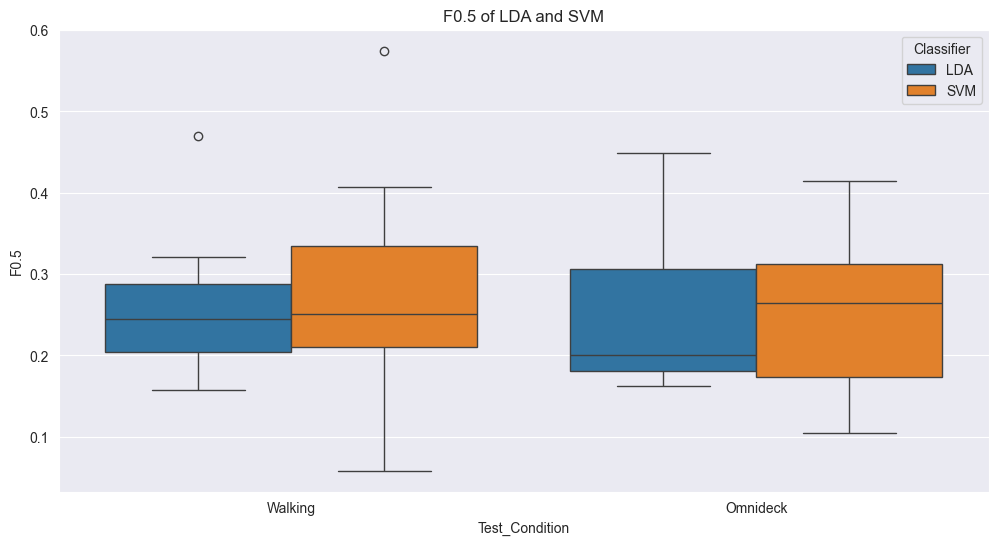

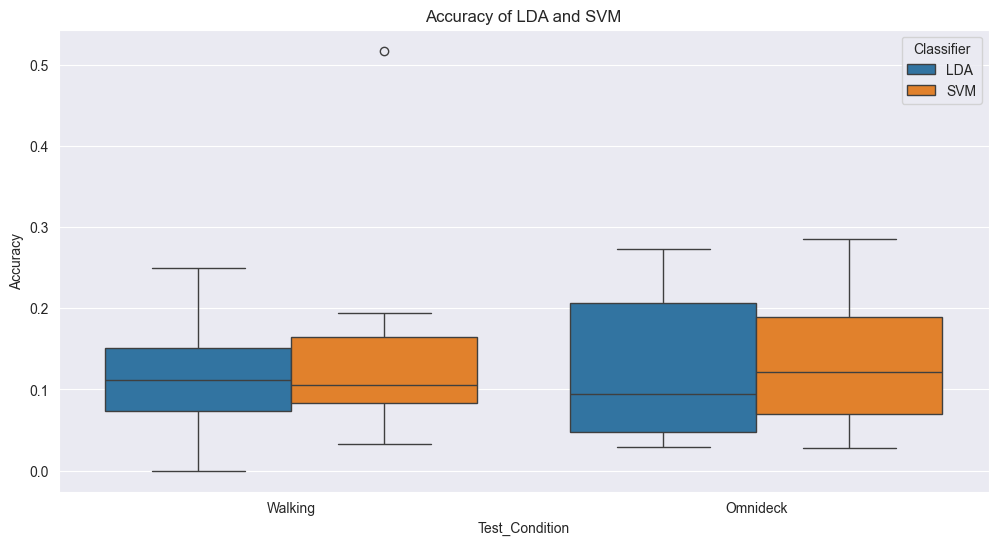

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_transfer = pd.read_csv("results\\transfer_learning_omideck_walking_first_1009_results.csv")

# Split based on training condition
df_transfer_omnideck = df_transfer[df_transfer['Train_Condition'] == 'Omnideck'].copy()
df_transfer_walking = df_transfer[df_transfer['Train_Condition'] == 'Walking'].copy()

# Add a column to label the training condition
df_transfer_omnideck['Train_Condition_Label'] = 'Omnideck'
df_transfer_walking['Train_Condition_Label'] = 'Walking'

# Combine both
df_combined = pd.concat([df_transfer_omnideck, df_transfer_walking], ignore_index=True)

measures = ['F0.5', 'Accuracy']

for measure in measures:
    # Melt the combined dataframe
    df_melted = pd.melt(
        df_combined,
        id_vars=['Participant', 'Test_Condition', 'Train_Condition_Label'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Optional: clean classifier names
    df_melted['Classifier'] = df_melted['Classifier'].str.replace(f'_{measure}', '', regex=False)

    # Create the boxplot with separate columns for training conditions
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Test_Condition',
        y=measure,
        hue='Classifier',
        data=df_melted,
    )

    plt.title(f'{measure} of LDA and SVM')
    plt.savefig(f'results\\{measure}_walking-omnideck_transfer_1009.png')
    plt.show()


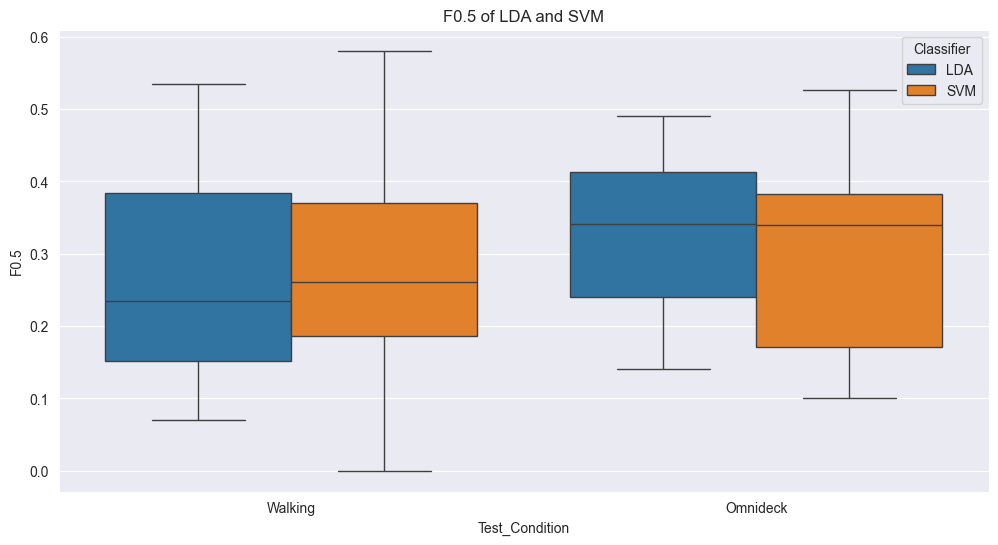

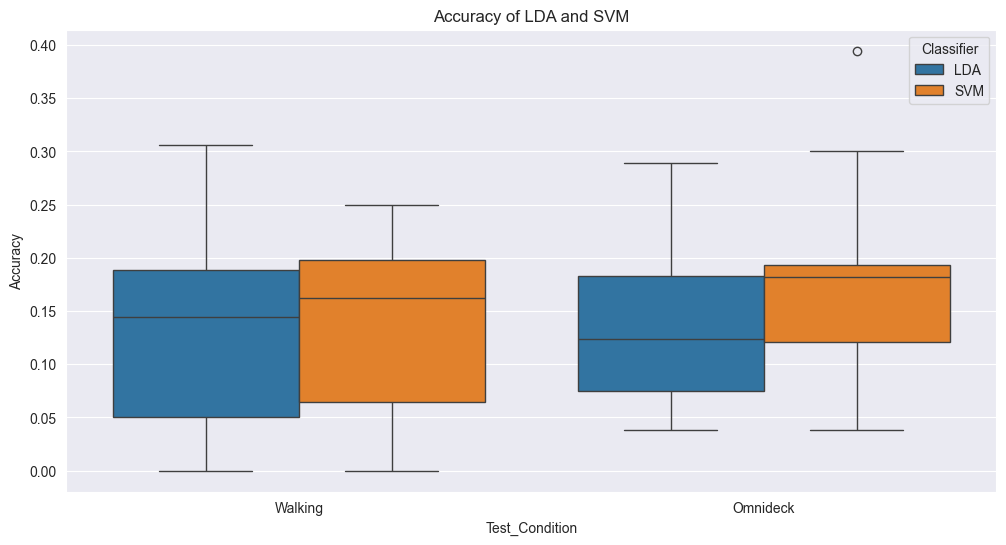

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df_transfer = pd.read_csv("results\\transfer_learning_omideck_walking_1029_results.csv")

# Split based on training condition
df_transfer_omnideck = df_transfer[df_transfer['Train_Condition'] == 'Omnideck'].copy()
df_transfer_walking = df_transfer[df_transfer['Train_Condition'] == 'Walking'].copy()

# Add a column to label the training condition
df_transfer_omnideck['Train_Condition_Label'] = 'Omnideck'
df_transfer_walking['Train_Condition_Label'] = 'Walking'

# Combine both
df_combined = pd.concat([df_transfer_omnideck, df_transfer_walking], ignore_index=True)

measures = ['F0.5', 'Accuracy']

for measure in measures:
    # Melt the combined dataframe
    df_melted = pd.melt(
        df_combined,
        id_vars=['Participant', 'Test_Condition', 'Train_Condition_Label'],
        value_vars=[f'LDA_{measure}', f'SVM_{measure}'],
        var_name='Classifier',
        value_name=measure
    )

    # Optional: clean classifier names
    df_melted['Classifier'] = df_melted['Classifier'].str.replace(f'_{measure}', '', regex=False)

    # Create the boxplot with separate columns for training conditions
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Test_Condition',
        y=measure,
        hue='Classifier',
        data=df_melted,
    )

    plt.title(f'{measure} of LDA and SVM')
    plt.savefig(f'results\\{measure}_walking-omnideck_transfer_1029.png')
    plt.show()


In [ ]:
# TODO: Individual Participants and Statistics